# Data Wrangling and EDA
## Business Problem
Leukemia is a type of cancer of the blood that often affects young people. In the past, pathologists would diagnose patients by eye after examining blood smear images under the microscope. But, this is time consuming and tedious. Advances in image recognition technology have come a long ways since their inception. Therefore, automated solutions using computers would be of great benefit to the medical community to aid in cancer diagnoses.

The goal of this project is to address the following question: How can the doctor’s at the Munich University Hospital automate the diagnosis of patients with leukemia using images from blood smears?

**Plan:**
Address the following questions:
* How many different morphology classes are there in the dataset?
* What are the image counts per morphology class?
* For each morphology class, what percentage of samples were re-annotated?
* Are there any samples there were re-annoted only once?

In [1]:
import os
import sys
sys.path.append('..')

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src import constants as con
from src.visualization import visualize as viz

# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
%matplotlib inline

## Load Annotations File
The above questions can be answered by exmaining the annotations file, _annotations.dat_.

In [2]:
df_annotate = pd.read_csv(os.path.join(con.REFERENCES_DIR, 'annotations.dat'), sep=' ', 
                          names=['Image Dir', 'Morphology', 'First Re-Annotation', 'Second Re-Annotation'])

In [3]:
df_annotate.head()

Image Dir Morphology First Re-Annotation Second Re-Annotation
0  BAS/BAS_0001.tiff        BAS                 NaN                  NaN
1  BAS/BAS_0002.tiff        BAS                 NaN                  NaN
2  BAS/BAS_0003.tiff        BAS                 NaN                  NaN
3  BAS/BAS_0004.tiff        BAS                 NaN                  NaN
4  BAS/BAS_0005.tiff        BAS                 NaN                  NaN

In [4]:
num_images = len(df_annotate)
print(f'There are {num_images} images in the dataset.')

There are 18365 images in the dataset.


## Data Exploration
### Morphology Classes

**Questions:**
* How many images are there per morphology?
* For each morphology, how many were re-annoted?

In [5]:
df_image_counts = viz.count_images(df_annotate)

In [6]:
df_image_counts.reset_index().loc[:, ['Morphology', 'Image Count']]

Morphology  Image Count
0         NGS         8484
1         LYT         3937
2         MYO         3268
3         MON         1789
4         EOS          424
5         NGB          109
6         BAS           79
7         EBO           78
8         PMO           70
9         MYB           42
10        MOB           26
11        PMB           18
12        KSC           15
13        MMZ           15
14        LYA           11

In [7]:
np.sum(df_image_counts['First Re-Annotation'].values)

1905

In [8]:
df_annotate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18365 entries, 0 to 18364
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Image Dir             18365 non-null  object
 1   Morphology            18365 non-null  object
 2   First Re-Annotation   1905 non-null   object
 3   Second Re-Annotation  1905 non-null   object
dtypes: object(4)
memory usage: 574.0+ KB


In [9]:
len(df_annotate.dropna())

1905

In [10]:
df_reannotated = df_annotate.dropna().copy()

In [11]:
df_reannotated.head()

Image Dir Morphology First Re-Annotation Second Re-Annotation
20  BAS/BAS_0021.tiff        BAS                 UNC                  UNC
25  BAS/BAS_0026.tiff        BAS                 BAS                  BAS
39  BAS/BAS_0040.tiff        BAS                 EOS                  EOS
51  BAS/BAS_0052.tiff        BAS                 BAS                  BAS
73  BAS/BAS_0074.tiff        BAS                 BAS                  BAS

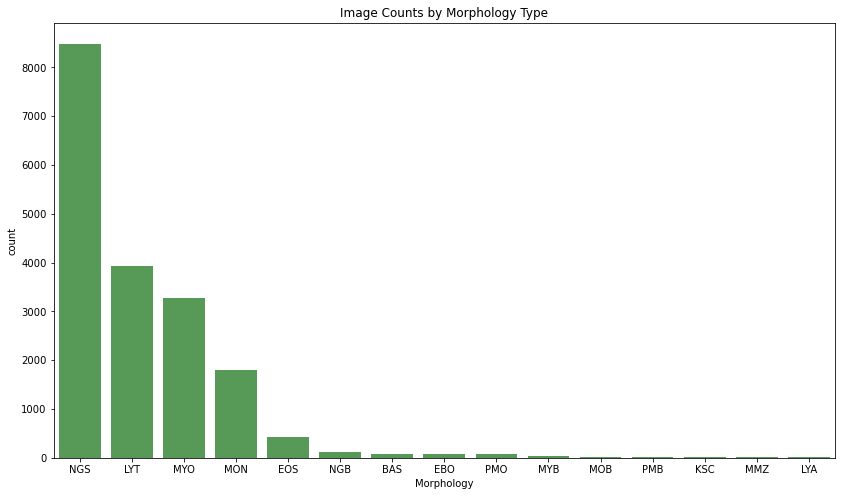

In [12]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.countplot(x='Morphology', data=df_annotate, order=df_image_counts.index.to_list(), color='green', alpha=0.7, ax=ax)
ax.set_title('Image Counts by Morphology Type')
plt.show()

**Observations:** 
* The category _NGC_ contains the most images.
* There is a steep drop-off in image counts across all morphology types.

## Re-Annoted Images

In [13]:
df_reannotated = df_annotate.dropna().copy()
df_reannotated.index = np.arange(len(df_reannotated))

In [14]:
df_reannotated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1905 entries, 0 to 1904
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Image Dir             1905 non-null   object
 1   Morphology            1905 non-null   object
 2   First Re-Annotation   1905 non-null   object
 3   Second Re-Annotation  1905 non-null   object
dtypes: object(4)
memory usage: 74.4+ KB


### Mature vs. Immature Leukocytes
This dataset was used in the paper, [Human-level recognition of blast cells in acute myeloid leukemia with convolutional neural networks](https://www.biorxiv.org/content/10.1101/564039v1.full). In Figure 2 of this paper, the 15 morphological types can be split into two groups, mature leukocytes and immature leukocytes. According to the article, [Normal leukocytes](https://eclinpath.com/hematology/morphologic-features/white-blood-cells/normal-leukocytes/), from the Cornel Univesity College of Vetrinary Medicine, EclinPath textbook, mature leukocytes are associated with a healthy body, while immature leukocytes are associated with disease. Often, patients with leukemia release immature leokocytes. Therefore, with this information, I will create an additional column to tag weather a leukocyte morphology is in the mature or immature group.

But, note, from this information I cannot deduce wether the patient has leukemia or not depending on the maturity of the leukocyte. This additional categorization only serves as an additional exploration of the dataset and relationships between leukocytes.

In [15]:
mature = ['BAS', 'EOS', 'LYA', 'LYT', 'MON', 'NGB', 'NGS']
immature = ['EBO', 'MMZ', 'MOB', 'MYB', 'MYO', 'PMB', 'PMO']
smudge = ['KSC']

In [16]:
df_annotate['Maturity'] = np.nan

In [17]:
df_annotate.loc[df_annotate['Morphology'].isin(mature), 'Maturity'] = 'mature'
df_annotate.loc[df_annotate['Morphology'].isin(immature), 'Maturity'] = 'immature'
df_annotate.loc[df_annotate['Morphology'].isin(smudge), 'Maturity'] = 'smudge'

In [18]:
df_maturity = pd.concat([df_annotate['Maturity'].value_counts(), df_annotate['Maturity'].value_counts(normalize=True)], axis=1)
df_maturity.columns = ['Count', 'Percentage']

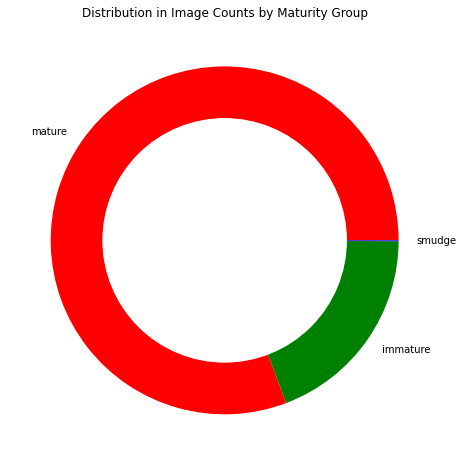

In [19]:
viz.plot_maturity(df_maturity)

In [20]:
df_maturity

Count  Percentage
mature    14833    0.807678
immature   3517    0.191506
smudge       15    0.000817

**Observations:**
Over 80% of the leukocytes fall in the mature category.

### Examine Images
For each morphology class, I will view an image small, to gain an understanding of the visual features for each.

In [21]:
image_list = df_annotate.groupby('Morphology').first()['Image Dir'].tolist()

**Questions:**
* What is the image shape?
* What do the images look like?
* How does image change when comparing each channel?

In [22]:
img = cv.imread(os.path.join(con.RAW_IMAGES_DIR, image_list[0]))

In [23]:
print(f'The image shape is {img.shape}.')

The image shape is (400, 400, 3).


**Observations:**
The three color channels indicates that the TIFF images follow a RGB format.

#### Images by morphology:

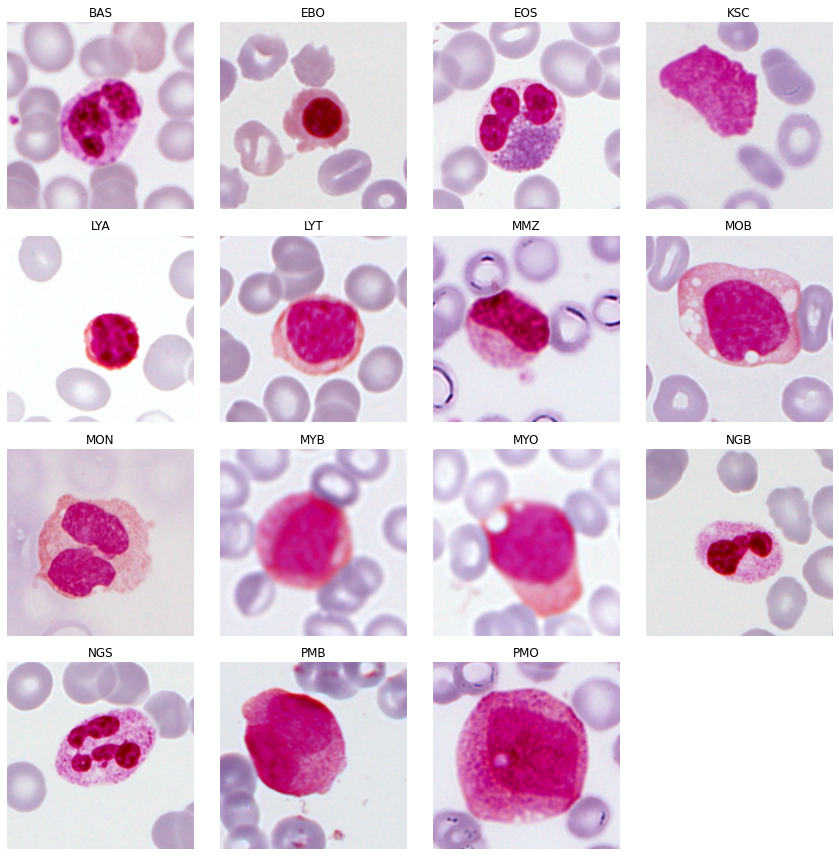

In [24]:
viz.display_images(image_list, 4)

#### Images by color channel:

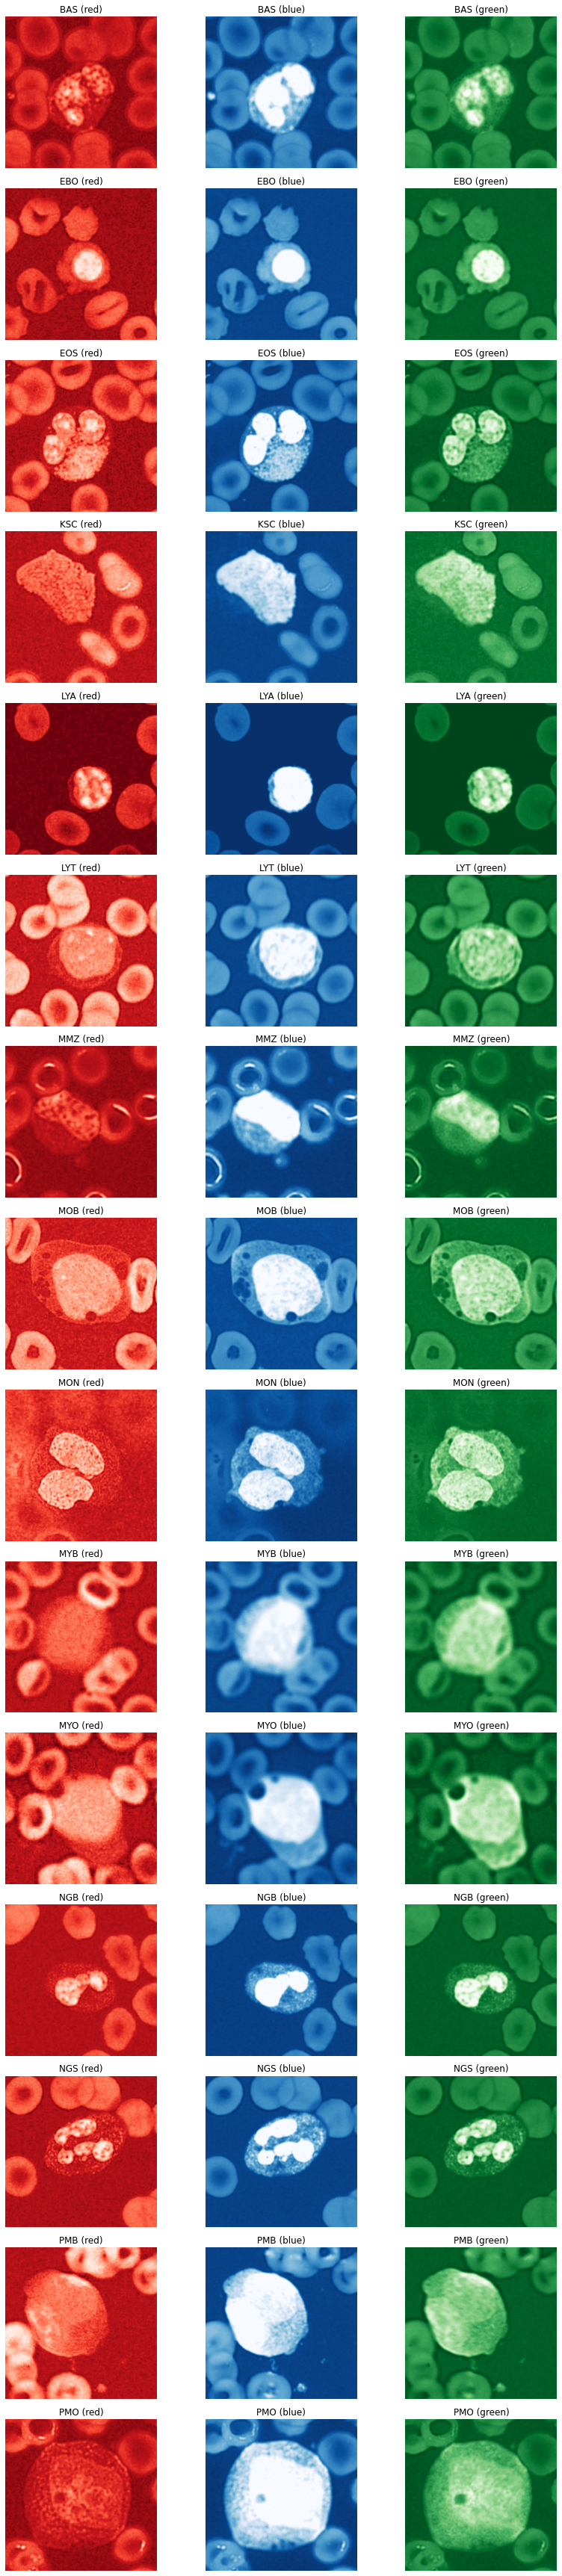

In [25]:
viz.display_images_by_channel(image_list)

### Image Statistics
How do the image statistics change across morphology and color channel?

In [26]:
df_summary = df_annotate.copy()

In [27]:
df_summary.set_index('Image Dir', inplace=True)

In [28]:
df_image_stats = viz.gather_image_stats(df_summary)

In [29]:
df_image_stats.head()

Image Dir Morphology First Re-Annotation Second Re-Annotation  \
0  BAS/BAS_0001.tiff        BAS                 NaN                  NaN   
1  BAS/BAS_0002.tiff        BAS                 NaN                  NaN   
2  BAS/BAS_0003.tiff        BAS                 NaN                  NaN   
3  BAS/BAS_0004.tiff        BAS                 NaN                  NaN   
4  BAS/BAS_0005.tiff        BAS                 NaN                  NaN   

  Maturity  Red_Max  Red_Min    Red_Mean  Red_Median  Green_Max  Green_Min  \
0   mature    252.0     62.0  207.835688       208.0      248.0        0.0   
1   mature    252.0      0.0  176.558337       204.0      249.0        0.0   
2   mature    255.0    131.0  220.211725       233.0      255.0        0.0   
3   mature    255.0    131.0  208.610944       217.0      255.0        0.0   
4   mature    255.0    119.0  204.626637       207.0      255.0        0.0   

   Green_Mean  Green_Median  Blue_Max  Blue_Min   Blue_Mean  Blue_Median  
0  174.517663         179.0     255.0       0.0  201.968513        204.0  
1  148.426038         178.0     255.0       0.0  174.189200        209.0  
2  204.425138         238.0     255.0      44.0  221.114937        239.0  
3  175.504075         196.0     255.0       1.0  208.230281        223.0  
4  173.551994         187.0     255.0       0.0  193.949400        204.0

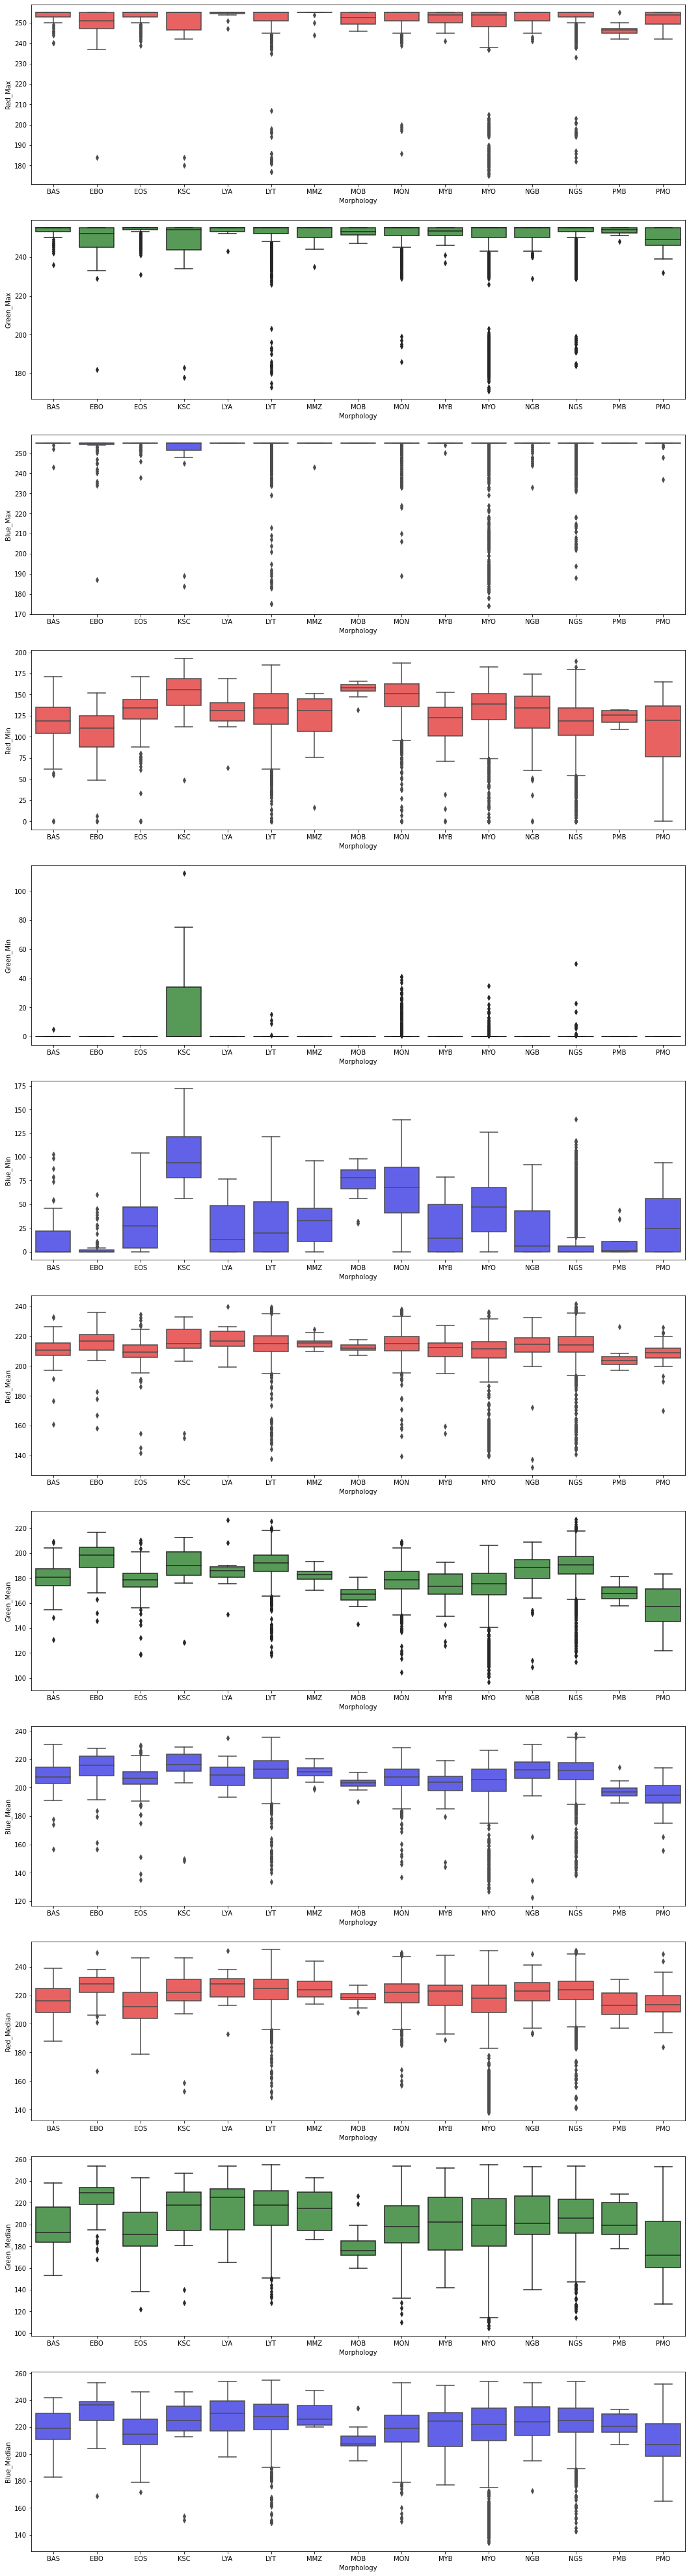

In [30]:
viz.plot_image_stats(df_image_stats)

### Save Updated Annotations
Save the updated annotations file, with the additional column Maturity, to the references directory.

In [31]:
df_annotate.to_csv(os.path.join(con.REFERENCES_DIR, 'annotations_updated.csv'), index=False)

## Summary
* Dataset
    * There are 18365 images in the dataset.
    * Each image is of type TIFF.
    * The image's shape is (400, 400, 4).
        * Four channels indicates a CMYK color scheme.
* Morphologies
    * There are 15 morphologies.
    * The morphologies can be divided into two groups, depending on maturity of the leukocyte in the image.
        * Mature indicates healthy.
        * Immature indicates not healthy.
* Class Imbalance
    * There exists a large class imbalance between the different morphological types.